In [1]:
import torch
import torchvision as vision
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv("../input/creditcardfraud/creditcard.csv")
df.rename(columns={'Class':'label'},inplace=True)
df=df.drop('Time',axis=1)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
fraud=df[df.label==1]
clean=df[df.label==0]
print("# of fraud samples {}. # of clean samples {} ".format(
            len(fraud),len(clean)))

# of fraud samples 492. # of clean samples 284315 


In [7]:
TRAINING_SAMPLE=200000
clean=clean.sample(frac=1).reset_index(drop=True)
train_input=clean.iloc[:TRAINING_SAMPLE].drop('label',axis=1)
test_input=clean.iloc[TRAINING_SAMPLE:].append(fraud)

In [8]:
test_input.label.value_counts()

0    84315
1      492
Name: label, dtype: int64

In [11]:
from sklearn.preprocessing import MinMaxScaler

pipeline=MinMaxScaler()
pipeline.fit(train_input)
X_test, y_test = test_input.drop('label', axis=1), test_input.label
X_train_transformed = pipeline.transform(train_input)
X_test_transformed = pipeline.transform(X_test)


In [15]:
from torch.utils.data import Dataset,DataLoader
class CustomDataset(Dataset):
    def __init__(self,data):
        #self.data=frame.to_numpy(dtype=np.float32)        
        self.data=data
    def __getitem__(self,idx):
            return torch.as_tensor(self.data[idx],dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)

In [16]:
train_dataset=CustomDataset(X_train_transformed)
train_loader=DataLoader(train_dataset,batch_size=256)

In [18]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(in_features=29,out_features=29)
        self.fc2=nn.Linear(in_features=29,out_features=16)
        self.fc3=nn.Linear(in_features=16,out_features=8)
        self.fc4=nn.Linear(in_features=8,out_features=4)
        self.fc5=nn.Linear(in_features=4,out_features=2)
        
        self.fc6=nn.Linear(in_features=2,out_features=4)
        self.fc7=nn.Linear(in_features=4,out_features=8)
        self.fc8=nn.Linear(in_features=8,out_features=16)
        self.fc9=nn.Linear(in_features=16,out_features=29)
        self.relu=nn.ELU()
    def forward(self,x):
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        x=self.relu(x)
        x=self.fc4(x)
        x=self.relu(x)
        x=self.fc5(x)
        x=self.relu(x)
        x=self.fc6(x)
        x=self.relu(x)
        x=self.fc7(x)
        x=self.relu(x)
        x=self.fc8(x)
        x=self.relu(x)
        x=self.fc9(x)
        x=self.relu(x)
        return x
        

In [20]:
from torch.nn import MSELoss
from torch.optim import Adam,SGD
model=Net()
optimizer=Adam(model.parameters())
#optimizer=SGD(model.parameters(),lr=0.6)
loss_fn=MSELoss()
epochs=50
for epoch in range(epochs):
    for x in train_loader:
        optimizer.zero_grad()
        y=model(x)
        loss=loss_fn(x,y)
        loss.backward()
        optimizer.step()
    print("epoch:{} loss {}".format(epoch,loss.item()))

epoch:0 loss 0.0018628268735483289
epoch:1 loss 0.0018612482817843556
epoch:2 loss 0.0018411134369671345
epoch:3 loss 0.001752279931679368
epoch:4 loss 0.0016498147742822766
epoch:5 loss 0.001574037130922079
epoch:6 loss 0.0015602570492774248
epoch:7 loss 0.0015426736790686846
epoch:8 loss 0.0015315673081204295
epoch:9 loss 0.0015226141549646854
epoch:10 loss 0.001504375017248094
epoch:11 loss 0.0014847484417259693
epoch:12 loss 0.0014741919003427029
epoch:13 loss 0.001470033428631723
epoch:14 loss 0.0014688567025586963
epoch:15 loss 0.0014688385417684913
epoch:16 loss 0.0014691613614559174
epoch:17 loss 0.001469564507715404
epoch:18 loss 0.0014699866296723485
epoch:19 loss 0.0014703719643875957
epoch:20 loss 0.00147053855471313
epoch:21 loss 0.001470355549827218
epoch:22 loss 0.001470060902647674
epoch:23 loss 0.0014679499436169863
epoch:24 loss 0.0014653231482952833
epoch:25 loss 0.0014660715823993087
epoch:26 loss 0.0014671571552753448
epoch:27 loss 0.0014661268796771765
epoch:28 lo

In [21]:
test_predict = model(torch.as_tensor(X_test_transformed,dtype=torch.float32))

In [22]:
mse = np.mean(np.power(X_test_transformed - test_predict.detach().numpy(), 2), axis=1)

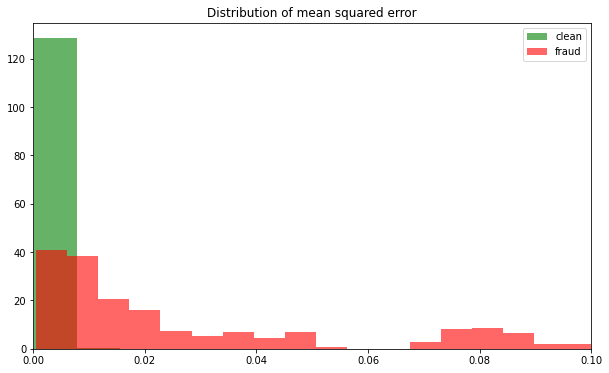

In [23]:
import matplotlib.pyplot as plt
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(10,6))


ax.hist(clean, bins=20, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=20, density=True, label="fraud", alpha=.6, color="red")
plt.xlim((0,0.1))
plt.title("Distribution of mean squared error")
plt.legend()
plt.show()

In [32]:
#outliers=mse>4*np.std(clean)
outliers=mse>np.mean(clean)+2*np.std(clean)

In [33]:
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(outliers,y_test)
# true/false positives/negatives
(tn, fn, 
 fp, tp) = cm.flatten()

In [34]:
print("Confusion matrix \n{}".format(cm))

print("precision: {:.2%}".format(tp/(fp+tp)))
print("recall: {:.2%}".format(tp/(fn+tp)))

Confusion matrix 
[[82937    86]
 [ 1378   406]]
precision: 22.76%
recall: 82.52%
